# Kyle Calabro
# DATA 750 - Thesis in Data Science
---

# Notebook Nine:
---
## Deploy transfer learning models with fine-tuning on the augmented training data, evaluate performance on testing data with grayscale images and contrast stretching.

In [ ]:
!pip install fsspec
!pip install gcsfs

import librosa
import librosa.display

%matplotlib inline
import matplotlib.pyplot as plt 
from matplotlib.pyplot import specgram

import seaborn as sns

import IPython.display as ipd
from IPython.display import Audio

import seaborn as sns

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
import sys
import warnings
import re

import time
import glob

from PIL import Image
from skimage import exposure, img_as_float

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, AveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, InputLayer, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import vgg16, vgg19, InceptionV3, Xception, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

# To ignore deprecation warnings...
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category = DeprecationWarning)

np.random.seed(42)
#tf.random.set_random_seed(42)

In [ ]:
from google.colab import auth
auth.authenticate_user()

project_id = 'quantum-bonus-330300'
!gcloud config set project {project_id}
!gsutil ls

bucket_name = 'kpc_thesis'

Updated property [core/project].
gs://kpc_thesis/


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Running on TPU  ['10.52.228.18:8470']
INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.52.228.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.52.228.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


# Utility Functions
---

In [ ]:
# To plot the accuracy of a CNN across epochs

def plot_accuracy(model_hist, model_title):
    plt.plot(model_hist.history["accuracy"])
    plt.plot(model_hist.history["val_accuracy"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Test"], loc = "best")
    plt.show();

In [ ]:
# To plot the loss of a CNN across epochs

def plot_loss(model_hist, model_title):
    plt.plot(model_hist.history["loss"])
    plt.plot(model_hist.history["val_loss"])
    plt.plot(figsize = (16, 16))
    plt.grid(True)
    plt.title(model_title)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(['Train', 'Test'], loc = "best")
    plt.show();

In [ ]:
# To get the predicted labels of a given CNN model
# Params:
    # test_dataset: tf.data dataset containing image tensors and corresponding labels
    # model: the CNN model to make predictions with
    # encoder: The label encoder object used to encode labels initially

def get_predictions(test_dataset, model, encoder):
    y_pred = model.predict(test_dataset)
    y_pred = y_pred.argmax(axis = 1)
    y_pred = y_pred.astype(int).flatten()
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred

In [ ]:
# To get the actual labels of a given CNN model
# Params:
    # y_test: target variable from the test set
    # encoder: The label encoder object used to encode labels initially

def get_labels(y_test, encoder):
    labels = y_test.argmax(axis = 1)
    labels = labels.astype(int).flatten()
    labels = encoder.inverse_transform(labels)
    return labels

In [ ]:
# To print a classification report based on predictions from a CNN 
# and provided actual labels
# Params:
    # labels: The actual labels of the target variable
    # y_pred: The predicted labels of the target variable
    # encoder: The label encoder object used to encode labels initially
    
def get_report(labels, y_pred, encoder):
    target_names = encoder.classes_
    print(classification_report(labels, y_pred, target_names))

In [ ]:
# To load an image from a Google Cloud Storage Bucket and convert to grayscale
# adjusting the contrast by a factor of two

# Params:
  # path: path to the image in the GCS bucket
  # label: the label corresponding to the image given by the path

def load_gs_f2_images(path, label):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image)
  image = tf.image.rgb_to_grayscale(image)
  image = tf.image.grayscale_to_rgb(image)
  image = tf.image.adjust_contrast(image, 2)
  image = tf.cast(image, tf.float32) / 255.0

  return image, label

# Bringing in the Data
----

In [ ]:
regex = re.compile(r"\d+")

In [ ]:
# Generate list of files containing the training images from the bucket
train_files = tf.io.gfile.glob("gs://kpc_thesis/Aug_Train/*.jpeg")

# Get the metadata of the images
train_metadata = pd.read_csv("gs://kpc_thesis/Aug_Train/aug_train.csv")
train_metadata.columns.values[0] = "corresponding_id"

# Match the images to their appropriate labels
index_list = [regex.findall(file)[0] for file in train_files]
index_list = list(map(int, index_list))

train_labels = [train_metadata.Emotion.iloc[index] for index in index_list]

In [ ]:
# Generate list of files containing the test images from the bucket
test_files = tf.io.gfile.glob("gs://kpc_thesis/Orig_Test/*.jpeg")

# Get the metadata of the images
test_metadata = pd.read_csv("gs://kpc_thesis/Orig_Test/orig_test_data.csv")
test_metadata.columns.values[0] = "corresponding_id"

# Match the images to their appropriate labels
index_list = [regex.findall(file)[0] for file in test_files]
index_list = list(map(int, index_list))

test_labels = [test_metadata.Emotion.iloc[index] for index in index_list]

In [ ]:
print("Number of Training Labels:", len(train_labels))

Number of Training Labels: 9216


In [ ]:
print("Number of Testing Labels:", len(test_labels))

Number of Testing Labels: 288


In [ ]:
# One-hot encoding
encoder = LabelEncoder()

y_train = to_categorical(encoder.fit_transform(train_labels))
y_test = to_categorical(encoder.fit_transform(test_labels))

In [ ]:
print(encoder.classes_)

['Angry' 'Calm' 'Disgust' 'Fear' 'Happy' 'Neutral' 'Sad' 'Surprise']


In [ ]:
# Create TF datasets from the images and corresponding labels
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, y_test))

In [ ]:
train_dataset = (train_dataset.map(load_gs_f2_images, num_parallel_calls = AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))
train_dataset

<PrefetchDataset shapes: ((None, None, None, 3), (None, 8)), types: (tf.float32, tf.float32)>

In [ ]:
test_dataset = (test_dataset.map(load_gs_f2_images, num_parallel_calls = AUTOTUNE)
            .batch(32)
            .prefetch(AUTOTUNE))
test_dataset

<PrefetchDataset shapes: ((None, None, None, 3), (None, 8)), types: (tf.float32, tf.float32)>

In [ ]:
# Define the input shape of the image tensors for the network
input_shape_orig = (217, 334, 3)

# VGG-16 Model Deployment with Fine-Tuning
---

### Last two convolutional blocks of the VGG-16 model are unfrozen, weights will change during training

In [ ]:
def create_model():
  vgg = vgg16.VGG16(include_top = False, weights = "imagenet", input_shape = input_shape_orig)

  output = vgg.layers[-1].output
  output = keras.layers.Flatten()(output)
  vgg_model = Model(vgg.input, output)

  vgg_model.trainable = True
  set_trainable = False

  for layer in vgg_model.layers:
    if layer.name in ["block5_conv1", "block4_conv1"]:
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
  
  model = Sequential()
  input_shape = vgg_model.output_shape[1]

  model.add(vgg_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model

with tpu_strategy.scope():
  model = create_model()
  model.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 30720)             14714688  
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_1 = time.time()

model_1_hist = model.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_1 = time.time()

Epoch 1/30
288/288 [==============================] - 203s 629ms/step - loss: 1.7478 - accuracy: 0.3313 - val_loss: 1.2823 - val_accuracy: 0.5208
Epoch 2/30
288/288 [==============================] - 199s 688ms/step - loss: 1.2598 - accuracy: 0.5358 - val_loss: 1.1308 - val_accuracy: 0.5799
Epoch 3/30
288/288 [==============================] - 210s 730ms/step - loss: 0.9713 - accuracy: 0.6469 - val_loss: 0.9404 - val_accuracy: 0.6667
Epoch 4/30
288/288 [==============================] - 204s 706ms/step - loss: 0.7311 - accuracy: 0.7439 - val_loss: 0.7400 - val_accuracy: 0.7535
Epoch 5/30
288/288 [==============================] - 203s 703ms/step - loss: 0.5635 - accuracy: 0.8005 - val_loss: 0.8502 - val_accuracy: 0.7326
Epoch 6/30
288/288 [==============================] - 234s 813ms/step - loss: 0.4276 - accuracy: 0.8499 - val_loss: 1.1678 - val_accuracy: 0.6701
Epoch 7/30
288/288 [==============================] - 207s 718ms/step - loss: 0.3239 - accuracy: 0.8881 - val_loss: 0.9645 -

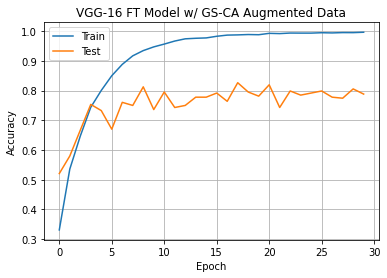

In [ ]:
plot_accuracy(model_1_hist, "VGG-16 FT Model w/ GS-CA Augmented Data")

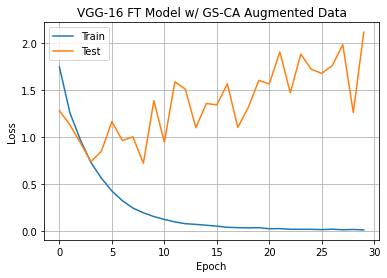

In [ ]:
plot_loss(model_1_hist, "VGG-16 FT Model w/ GS-CA Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_1 - start_time_model_1), "\n")

Elapsed Training Time: 6348.6013951301575 seconds 



In [ ]:
model.evaluate(test_dataset)

9/9 [==============================] - 7s 682ms/step - loss: 2.1172 - accuracy: 0.7882


[2.117161273956299, 0.788194477558136]

In [ ]:
y_pred_model_1 = get_predictions(test_dataset, model, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_1, encoder)

              precision    recall  f1-score   support

       Angry       0.62      0.94      0.75        35
        Calm       0.79      0.86      0.83        36
     Disgust       0.91      0.79      0.85        39
        Fear       0.90      0.68      0.77        40
       Happy       0.88      0.64      0.74        36
     Neutral       0.84      0.88      0.86        24
         Sad       0.65      0.58      0.61        38
    Surprise       0.83      0.97      0.90        40

    accuracy                           0.79       288
   macro avg       0.80      0.79      0.79       288
weighted avg       0.80      0.79      0.79       288



In [ ]:
model.save("/content/drive/My Drive/Thesis/RAVDESS/VGG16_FT_GS-CA_Aug_Data_TPU.h5")

# VGG-19 Model Deployment with Fine Tuning
---

In [ ]:
def create_model():
  vgg_19 = vgg19.VGG19(include_top = False, weights = "imagenet", input_shape = input_shape_orig)

  output = vgg_19.layers[-1].output
  output = keras.layers.Flatten()(output)
  vgg19_model = Model(vgg_19.input, output)

  vgg19_model.trainable = True
  set_trainable = False

  for layer in vgg19_model.layers:
    if layer.name in ["block5_conv1", "block4_conv1"]:
      set_trainable = True
    if set_trainable:
      layer.trainable = True
    else:
      layer.trainable = False
  
  model = Sequential()
  input_shape = vgg19_model.output_shape[1]

  model.add(vgg19_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model

with tpu_strategy.scope():
  model_3 = create_model()
  model_3.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_3.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 30720)             20024384  
_________________________________________________________________
dense (Dense)                (None, 512)               15729152  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_3 = time.time()

model_3_hist = model_3.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_3 = time.time()

Epoch 1/30
288/288 [==============================] - 207s 628ms/step - loss: 1.7660 - accuracy: 0.3254 - val_loss: 1.3290 - val_accuracy: 0.4896
Epoch 2/30
288/288 [==============================] - 202s 700ms/step - loss: 1.3092 - accuracy: 0.5186 - val_loss: 1.0385 - val_accuracy: 0.6181
Epoch 3/30
288/288 [==============================] - 206s 714ms/step - loss: 1.0034 - accuracy: 0.6379 - val_loss: 0.9756 - val_accuracy: 0.6667
Epoch 4/30
288/288 [==============================] - 206s 715ms/step - loss: 0.7641 - accuracy: 0.7303 - val_loss: 0.8109 - val_accuracy: 0.7431
Epoch 5/30
288/288 [==============================] - 221s 767ms/step - loss: 0.5759 - accuracy: 0.8011 - val_loss: 1.1179 - val_accuracy: 0.6493
Epoch 6/30
288/288 [==============================] - 218s 756ms/step - loss: 0.4350 - accuracy: 0.8502 - val_loss: 0.8645 - val_accuracy: 0.7500
Epoch 7/30
288/288 [==============================] - 210s 729ms/step - loss: 0.3275 - accuracy: 0.8880 - val_loss: 0.8872 -

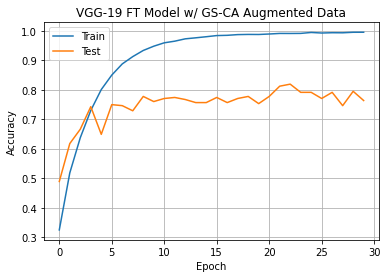

In [ ]:
plot_accuracy(model_3_hist, "VGG-19 FT Model w/ GS-CA Augmented Data")

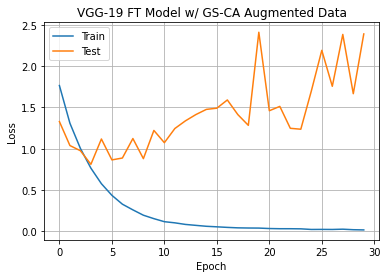

In [ ]:
plot_loss(model_3_hist, "VGG-19 FT Model w/ GS-CA Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_3 - start_time_model_3), "\n")

Elapsed Training Time: 6327.799028873444 seconds 



In [ ]:
model_3.evaluate(test_dataset)

9/9 [==============================] - 8s 694ms/step - loss: 2.3916 - accuracy: 0.7639


[2.3916468620300293, 0.7638888955116272]

In [ ]:
y_pred_model_3 = get_predictions(test_dataset, model_3, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_3, encoder)

              precision    recall  f1-score   support

       Angry       0.74      0.71      0.72        35
        Calm       0.71      1.00      0.83        36
     Disgust       0.80      0.85      0.83        39
        Fear       0.83      0.62      0.71        40
       Happy       0.66      0.69      0.68        36
     Neutral       0.79      0.79      0.79        24
         Sad       0.74      0.61      0.67        38
    Surprise       0.87      0.85      0.86        40

    accuracy                           0.76       288
   macro avg       0.77      0.77      0.76       288
weighted avg       0.77      0.76      0.76       288



In [ ]:
model_3.save("/content/drive/My Drive/Thesis/RAVDESS/VGG19_FT_GS-CA_Aug_Data_TPU.h5")

# InceptionV3 Model Deployment with Fine Tuning
---

In [ ]:
def create_model():
  inception = InceptionV3(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = inception.layers[-1].output
  output = Flatten()(output)
  inception_model = Model(inception.input, output)

  inception_model.trainable = True

  layer_num = len(inception_model.layers)
  for layer in inception_model.layers[:279]:
    layer.trainable = False

  for layer in inception_model.layers[279:]:
    layer.trainable = True

  model = Sequential()
  input_shape = inception_model.output_shape[1]

  model.add(inception_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model

In [ ]:
with tpu_strategy.scope():
  model_4 = create_model()
  model_4.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_4.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 92160)             21802784  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               47186432  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_______________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_4 = time.time()

model_4_hist = model_4.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_4 = time.time()

Epoch 1/30
288/288 [==============================] - 265s 823ms/step - loss: 1.8330 - accuracy: 0.3137 - val_loss: 1.4455 - val_accuracy: 0.4965
Epoch 2/30
288/288 [==============================] - 229s 796ms/step - loss: 1.4360 - accuracy: 0.4756 - val_loss: 1.3007 - val_accuracy: 0.5417
Epoch 3/30
288/288 [==============================] - 214s 742ms/step - loss: 1.1236 - accuracy: 0.6024 - val_loss: 1.1848 - val_accuracy: 0.5764
Epoch 4/30
288/288 [==============================] - 197s 684ms/step - loss: 0.8644 - accuracy: 0.6976 - val_loss: 1.2216 - val_accuracy: 0.5660
Epoch 5/30
288/288 [==============================] - 213s 739ms/step - loss: 0.6518 - accuracy: 0.7769 - val_loss: 1.1986 - val_accuracy: 0.6042
Epoch 6/30
288/288 [==============================] - 217s 754ms/step - loss: 0.4667 - accuracy: 0.8459 - val_loss: 1.1867 - val_accuracy: 0.6389
Epoch 7/30
288/288 [==============================] - 214s 743ms/step - loss: 0.3441 - accuracy: 0.8881 - val_loss: 1.1889 -

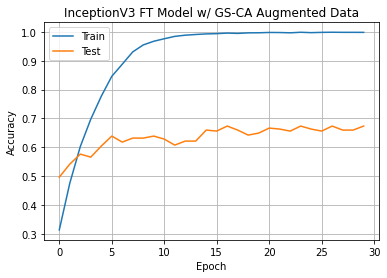

In [ ]:
plot_accuracy(model_4_hist, "InceptionV3 FT Model w/ GS-CA Augmented Data")

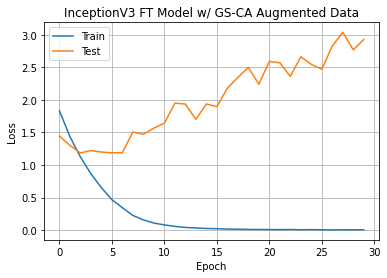

In [ ]:
plot_loss(model_4_hist, "InceptionV3 FT Model w/ GS-CA Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_4 - start_time_model_4), "\n")

Elapsed Training Time: 6642.671543121338 seconds 



In [ ]:
model_4.evaluate(test_dataset)

9/9 [==============================] - 10s 830ms/step - loss: 2.9260 - accuracy: 0.6736


[2.925963878631592, 0.6736111044883728]

In [ ]:
y_pred_model_4 = get_predictions(test_dataset, model_4, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_4, encoder)

              precision    recall  f1-score   support

       Angry       0.66      0.60      0.63        35
        Calm       0.76      0.81      0.78        36
     Disgust       0.65      0.79      0.71        39
        Fear       0.79      0.47      0.59        40
       Happy       0.66      0.64      0.65        36
     Neutral       0.65      0.83      0.73        24
         Sad       0.50      0.37      0.42        38
    Surprise       0.71      0.93      0.80        40

    accuracy                           0.67       288
   macro avg       0.67      0.68      0.67       288
weighted avg       0.67      0.67      0.66       288



In [ ]:
model_4.save("/content/drive/My Drive/Thesis/RAVDESS/InceptionV3_FT_GS-CA_Aug_Data_TPU.h5")

# Xception Model Deployment with Fine Tuning
---

In [ ]:
def create_model():
  xception = Xception(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = xception.layers[-1].output
  output = Flatten()(output)
  xception_model = Model(xception.input, output)

  xception_model.trainable = True

  layer_num = len(xception_model.layers)
  for i, layer in enumerate(xception_model.layers):
    if i < 15:
      layer.trainable = False
    else:
      layer.trainable = True

  model = Sequential()
  input_shape = xception_model.output_shape[1]

  model.add(xception_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model      

In [ ]:
with tpu_strategy.scope():
  model_5 = create_model()
  model_5.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_5.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_2 (Functional)         (None, 157696)            20861480  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               80740864  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_______________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_5 = time.time()

model_5_hist = model_5.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_5 = time.time()

Epoch 1/30
288/288 [==============================] - 271s 724ms/step - loss: 1.8384 - accuracy: 0.2928 - val_loss: 1.4528 - val_accuracy: 0.4931
Epoch 2/30
288/288 [==============================] - 208s 723ms/step - loss: 1.3419 - accuracy: 0.5103 - val_loss: 1.2042 - val_accuracy: 0.5729
Epoch 3/30
288/288 [==============================] - 211s 731ms/step - loss: 0.9039 - accuracy: 0.6883 - val_loss: 1.1539 - val_accuracy: 0.5938
Epoch 4/30
288/288 [==============================] - 224s 777ms/step - loss: 0.5534 - accuracy: 0.8107 - val_loss: 1.1689 - val_accuracy: 0.6389
Epoch 5/30
288/288 [==============================] - 200s 695ms/step - loss: 0.2817 - accuracy: 0.9103 - val_loss: 1.4530 - val_accuracy: 0.6215
Epoch 6/30
288/288 [==============================] - 215s 748ms/step - loss: 0.1409 - accuracy: 0.9588 - val_loss: 1.4558 - val_accuracy: 0.6424
Epoch 7/30
288/288 [==============================] - 212s 736ms/step - loss: 0.0638 - accuracy: 0.9837 - val_loss: 1.6897 -

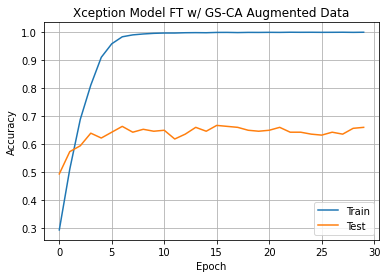

In [ ]:
plot_accuracy(model_5_hist, "Xception Model FT w/ GS-CA Augmented Data")

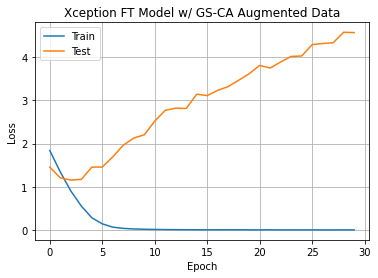

In [ ]:
plot_loss(model_5_hist, "Xception FT Model w/ GS-CA Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_5 - start_time_model_5), "\n")

Elapsed Training Time: 6488.995577335358 seconds 



In [ ]:
model_5.evaluate(test_dataset)

9/9 [==============================] - 8s 725ms/step - loss: 4.5669 - accuracy: 0.6597


[4.566885471343994, 0.6597222089767456]

In [ ]:
y_pred_model_5 = get_predictions(test_dataset, model_5, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_5, encoder)

              precision    recall  f1-score   support

       Angry       0.55      0.80      0.65        35
        Calm       0.70      0.92      0.80        36
     Disgust       0.70      0.79      0.75        39
        Fear       0.87      0.50      0.63        40
       Happy       0.60      0.50      0.55        36
     Neutral       0.61      0.46      0.52        24
         Sad       0.53      0.45      0.49        38
    Surprise       0.74      0.80      0.77        40

    accuracy                           0.66       288
   macro avg       0.66      0.65      0.64       288
weighted avg       0.67      0.66      0.65       288



In [ ]:
model_5.save("/content/drive/My Drive/Thesis/RAVDESS/Xception_FT_GS-CA_Aug_Data_TPU.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# ResNet-50 Model Deployment with Fine Tuning
---

In [ ]:
def create_model():
  resnet = ResNet50(weights = "imagenet", include_top = False, input_shape = input_shape_orig)

  output = resnet.layers[-1].output
  output = Flatten()(output)
  resnet_model = Model(resnet.input, output)

  resnet_model.trainable = False

  model = Sequential()
  input_shape = resnet_model.output_shape[1]

  model.add(resnet_model)
  model.add(Dense(512, activation = "relu", input_dim = input_shape))
  model.add(Dropout(.3))
  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(.3))
  model.add(Dense(8, activation = "softmax"))

  return model      

In [ ]:
with tpu_strategy.scope():
  model_6 = create_model()
  model_6.compile(loss = "categorical_crossentropy", optimizer = optimizers.RMSprop(lr = 1e-5), metrics = ["accuracy"])

model_6.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 157696)            23587712  
_________________________________________________________________
dense_12 (Dense)             (None, 512)               80740864  
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_______________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
start_time_model_6 = time.time()

model_6_hist = model_6.fit(train_dataset, epochs = 30, validation_data = test_dataset, verbose = 1)

end_time_model_6 = time.time()

Epoch 1/30
288/288 [==============================] - 286s 856ms/step - loss: 2.0910 - accuracy: 0.1669 - val_loss: 2.0182 - val_accuracy: 0.1771
Epoch 2/30
288/288 [==============================] - 213s 740ms/step - loss: 1.9820 - accuracy: 0.2120 - val_loss: 1.9833 - val_accuracy: 0.1806
Epoch 3/30
288/288 [==============================] - 213s 740ms/step - loss: 1.9289 - accuracy: 0.2464 - val_loss: 1.9007 - val_accuracy: 0.2431
Epoch 4/30
288/288 [==============================] - 224s 777ms/step - loss: 1.8695 - accuracy: 0.2807 - val_loss: 1.8602 - val_accuracy: 0.2812
Epoch 5/30
288/288 [==============================] - 217s 751ms/step - loss: 1.8229 - accuracy: 0.3034 - val_loss: 1.7829 - val_accuracy: 0.3333
Epoch 6/30
288/288 [==============================] - 215s 746ms/step - loss: 1.7837 - accuracy: 0.3276 - val_loss: 1.7516 - val_accuracy: 0.3507
Epoch 7/30
288/288 [==============================] - 209s 726ms/step - loss: 1.7339 - accuracy: 0.3520 - val_loss: 1.7144 -

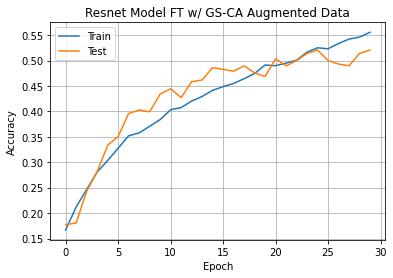

In [ ]:
plot_accuracy(model_6_hist, "Resnet Model FT w/ GS-CA Augmented Data")

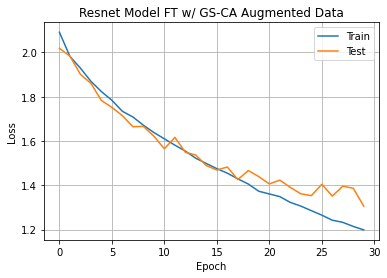

In [ ]:
plot_loss(model_6_hist, "Resnet Model FT w/ GS-CA Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_model_6 - start_time_model_6), "\n")

Elapsed Training Time: 6550.847141027451 seconds 



In [ ]:
model_6.evaluate(test_dataset)

9/9 [==============================] - 7s 676ms/step - loss: 1.3054 - accuracy: 0.5208


[1.3053675889968872, 0.5208333134651184]

In [ ]:
y_pred_model_6 = get_predictions(test_dataset, model_6, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_model_6, encoder)

              precision    recall  f1-score   support

       Angry       0.40      0.91      0.56        35
        Calm       0.64      0.83      0.72        36
     Disgust       0.67      0.67      0.67        39
        Fear       0.58      0.38      0.45        40
       Happy       0.32      0.25      0.28        36
     Neutral       0.45      0.21      0.29        24
         Sad       0.30      0.16      0.21        38
    Surprise       0.73      0.68      0.70        40

    accuracy                           0.52       288
   macro avg       0.51      0.51      0.48       288
weighted avg       0.52      0.52      0.50       288



In [ ]:
model_6.save("/content/drive/My Drive/Thesis/RAVDESS/Resnet_GS-CA_FT_Aug_Data_TPU.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# AlexNet
---


In [ ]:
def create_model():
  #Instantiation
  AlexNet = Sequential()

  #1st Convolutional Layer
  AlexNet.add(Conv2D(filters = 96, input_shape = input_shape_orig, kernel_size = (11,11), strides = (4, 4), padding = "same"))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'same'))

  #2nd Convolutional Layer
  AlexNet.add(Conv2D(filters = 256, kernel_size = (5, 5), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #3rd Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #4th Convolutional Layer
  AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))

  #5th Convolutional Layer
  AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #Passing it to a Fully Connected layer
  AlexNet.add(Flatten())
  # 1st Fully Connected Layer
  AlexNet.add(Dense(512, input_shape=input_shape_orig))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  # Add Dropout to prevent overfitting
  AlexNet.add(Dropout(0.4))

  #2nd Fully Connected Layer
  AlexNet.add(Dense(512))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  #Add Dropout
  AlexNet.add(Dropout(0.4))

  #3rd Fully Connected Layer
  AlexNet.add(Dense(256))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('relu'))
  #Add Dropout
  AlexNet.add(Dropout(0.4))

  #Output Layer
  AlexNet.add(Dense(8))
  AlexNet.add(BatchNormalization())
  AlexNet.add(Activation('softmax'))

  return AlexNet

In [ ]:
with tpu_strategy.scope():
  AlexNet = create_model()
  AlexNet.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy'])
  
AlexNet.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 55, 84, 96)        34944     
_________________________________________________________________
batch_normalization_98 (Batc (None, 55, 84, 96)        384       
_________________________________________________________________
activation_94 (Activation)   (None, 55, 84, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 42, 96)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 28, 42, 256)       614656    
_________________________________________________________________
batch_normalization_99 (Batc (None, 28, 42, 256)       1024      
_________________________________________________________________
activation_95 (Activation)   (None, 28, 42, 256)      

In [ ]:
lrr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = .01, patience = 3, min_lr = 1e-5) 

In [ ]:
start_time_alexnet = time.time()

alexnet_hist = AlexNet.fit(train_dataset, epochs = 30, validation_data = test_dataset, callbacks = [lrr], verbose = 1)

end_time_alexnet = time.time()

Epoch 1/30
288/288 [==============================] - 224s 700ms/step - loss: 1.9962 - accuracy: 0.2425 - val_loss: 2.1735 - val_accuracy: 0.1736
Epoch 2/30
288/288 [==============================] - 212s 737ms/step - loss: 1.8349 - accuracy: 0.3003 - val_loss: 1.8641 - val_accuracy: 0.3090
Epoch 3/30
288/288 [==============================] - 218s 757ms/step - loss: 1.7396 - accuracy: 0.3366 - val_loss: 2.6333 - val_accuracy: 0.1632
Epoch 4/30
288/288 [==============================] - 225s 782ms/step - loss: 1.6550 - accuracy: 0.3803 - val_loss: 2.3109 - val_accuracy: 0.2500
Epoch 5/30
288/288 [==============================] - 226s 783ms/step - loss: 1.5634 - accuracy: 0.4127 - val_loss: 2.6496 - val_accuracy: 0.2535
Epoch 6/30
288/288 [==============================] - 217s 752ms/step - loss: 1.4780 - accuracy: 0.4448 - val_loss: 1.1920 - val_accuracy: 0.5556
Epoch 7/30
288/288 [==============================] - 227s 788ms/step - loss: 1.4577 - accuracy: 0.4532 - val_loss: 1.1712 -

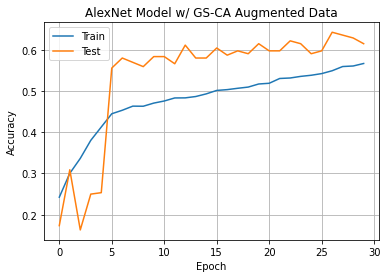

In [ ]:
plot_accuracy(alexnet_hist, "AlexNet Model w/ GS-CA Augmented Data")

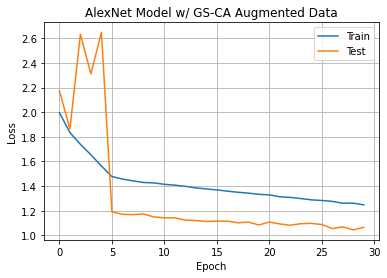

In [ ]:
plot_loss(alexnet_hist, "AlexNet Model w/ GS-CA Augmented Data")

In [ ]:
print("Elapsed Training Time: {} seconds".format(end_time_alexnet - start_time_alexnet), "\n")

Elapsed Training Time: 6103.746301651001 seconds 



In [ ]:
AlexNet.evaluate(test_dataset)

9/9 [==============================] - 7s 618ms/step - loss: 1.0663 - accuracy: 0.6146


[1.066324234008789, 0.6145833134651184]

In [ ]:
y_pred_alexnet = get_predictions(test_dataset, AlexNet, encoder)

In [ ]:
y_labels = get_labels(y_test, encoder)

In [ ]:
get_report(y_labels, y_pred_alexnet, encoder)

              precision    recall  f1-score   support

       Angry       0.59      0.83      0.69        35
        Calm       0.66      0.75      0.70        36
     Disgust       0.72      0.85      0.78        39
        Fear       0.71      0.50      0.59        40
       Happy       0.43      0.36      0.39        36
     Neutral       0.67      0.42      0.51        24
         Sad       0.55      0.29      0.38        38
    Surprise       0.58      0.85      0.69        40

    accuracy                           0.61       288
   macro avg       0.61      0.61      0.59       288
weighted avg       0.61      0.61      0.60       288



In [ ]:
AlexNet.save("/content/drive/My Drive/Thesis/RAVDESS/AlexNet_GS-CA_Aug_Data_TPU.h5")